In [1]:
import torch
torch.__version__

'1.13.1+cu117'

In [2]:
import sys
sys.path.append('..')

In [3]:
from simulators import GLU
from inference_utils import get_prior

dim_x = 10
n_sims = 1000
n_params = 10

prior = get_prior('GLU')
theta = prior.sample((n_sims,))

X = torch.empty((n_sims,dim_x))
for i in range(n_sims):
    X[i] = GLU(theta[i])
X

tensor([[ 0.0527, -0.4444,  0.9823,  ...,  0.0696,  0.0403,  0.1025],
        [-0.1951, -0.4709, -0.9454,  ...,  0.2005, -0.6851, -0.6567],
        [-0.4421, -1.5885,  0.3279,  ...,  0.3623, -0.2176,  0.7423],
        ...,
        [ 0.2830, -0.3462, -0.7682,  ...,  0.9877, -0.1191, -0.3250],
        [ 0.4519, -0.4608, -1.4131,  ..., -1.1042, -0.4081,  0.6474],
        [ 0.2433,  0.3422,  0.6685,  ...,  0.2402,  0.2187, -1.2266]])

In [4]:
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

test_theta = torch.from_numpy(np.array(pd.read_csv('tests/test_thetas.csv', index_col=0)))
test_theta = torch.tensor(test_theta, dtype=torch.float32)
test_X = torch.empty(len(test_theta),dim_x)
for i in range(len(test_theta)):
    test_X[i] = GLU(test_theta[i]) 

acc_cp = pd.read_csv('tests/accus_GLU.csv', index_col=0)

acc_tabpfn = np.zeros(shape=(n_params,len(test_theta)))

for i in range(n_params):
    y0 = theta[:,i].numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y0, test_size=0.20, random_state=42)
    reg = TabPFNRegressor(random_state=42)
    reg.fit(X_train, y_train)
    pred = reg.predict(test_X.numpy())
    acc_tabpfn[i] = pred - test_theta[:,i].numpy()

/tmp/ipykernel_2312004/846191576.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_theta = torch.tensor(test_theta, dtype=torch.float32)
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [6]:
posterior = pickle.load(open('posteriors/posterior_GLU_1000_20.pkl', 'rb'))
npe_samples = posterior.sample_batched((1000,), x = test_X)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

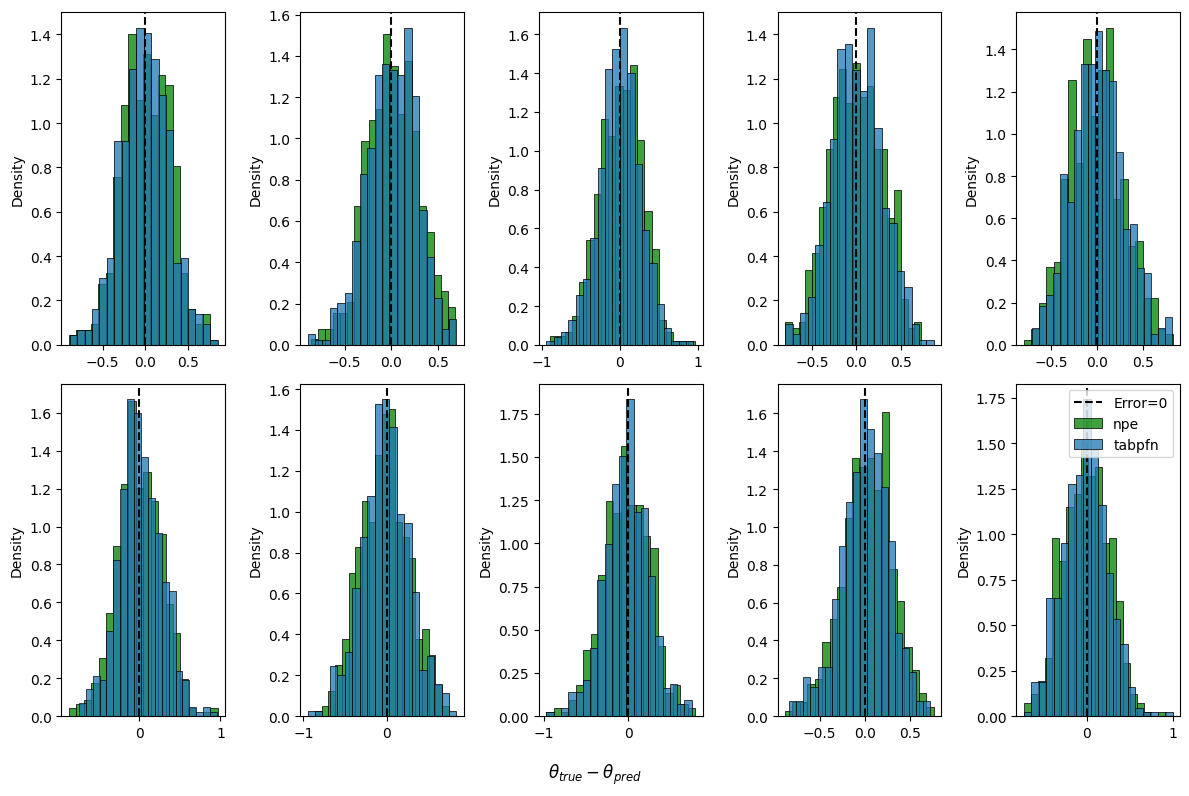

In [7]:
from seaborn import histplot

fig, ax = plt.subplots(2,n_params//2,figsize=(12,8), tight_layout=True)
fig.supxlabel('$θ_{true} - θ_{pred}$')

for i in range(n_params):
    j = i%2, i//2
    # histplot(acc_cp.iloc[:,i], label='cp', color='red', bins=20, stat='density', ax = ax[j])
    histplot(npe_samples[:,:,i].mean(0)-test_theta[:,i], label='npe', color='green', bins=20, stat='density', ax = ax[j])
    histplot(acc_tabpfn[i], label='tabpfn', bins=20, stat='density', ax = ax[j])
    ax[j].axvline(0, color='k', ls='--', label='Error=0')

plt.legend()


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y0, test_size=0.20, random_state=42)
reg = TabPFNRegressor(random_state=42)
reg.fit(X_train, y_train)
quantiles = [0.025,0.975]
pred_tabpfn_0 = reg.predict(test_X.numpy(), output_type="quantiles", quantiles=quantiles)

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function

In [11]:
pre_covs_tabpfn = (test_theta[:,-1].numpy() > pred_tabpfn_0[0]) * (test_theta[:,-1].numpy() < pred_tabpfn_0[1])
covs_tab_pfn = pre_covs_tabpfn.mean()

In [12]:
covs_tab_pfn

0.956